# Modeling a pandemic

By Christian Graf, August 2020

See https://bitbucket.org/chgraf/blog/src/master/Agent%20Based%20Pandemic/

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import pandas as pd

from tqdm import tqdm

np.random.seed = 42
_nAgents = 1000
_randomContacts = 9
_chanceOfInfection = 0.025

_mortalityRate = 0.05

_daysBeingInfectious = 10
_daysCuredAfter = 10

In [6]:
# Calculating analytical predictions with SIR-Model
class MathModel:
    S = 0
    I = 0
    R = 0
    
    S_ = []
    I_ = []
    R_ = []
    
    beta = 0
    gamma = 0

    chanceOfInfection = 0
    randomContacts = 0
    daysCuredAfter = 1
    
    def __init__(self, nAgents, nPatientZero, chanceOfInfection, randomContacts, daysCuredAfter):
        
        self.chanceOfInfection = chanceOfInfection
        self.randomContacts = randomContacts
        self.daysCuredAfter = daysCuredAfter
        
        self.S = nAgents - nPatientZero
        self.I = nPatientZero
        self.R = 0
        
        self.S_ = []
        self.I_ = []
        self.R_ = []
        
        self.beta = self.chanceOfInfection*self.randomContacts #contacts with 100% infection rate
        self.gamma = 1./self.daysCuredAfter
    
        print("Math Model initialized with:")
        print("Beta:",self.beta)
        print("Gamma:",self.gamma)
        
    def calculateStep(self):
        N = self.S+self.I+self.R
        
        S = self.S
        I = self.I

        self.S = S - self.beta*S*I/N
        # People who just got infected can be immediately cured. 
        # This may not be very accurate but it is easier to implement
        # In the agent based model
        newI = I + self.beta*S*I/N 
        self.I = I + self.beta*S*I/N - self.gamma*newI
        self.R = self.R + self.gamma*newI
        
        self.S_.append(self.S)
        self.I_.append(self.I)
        self.R_.append(self.R)    

Math Model initialized with:
Beta: 0.225
Gamma: 0.1
Simulate SIR Model


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 698081.11it/s]


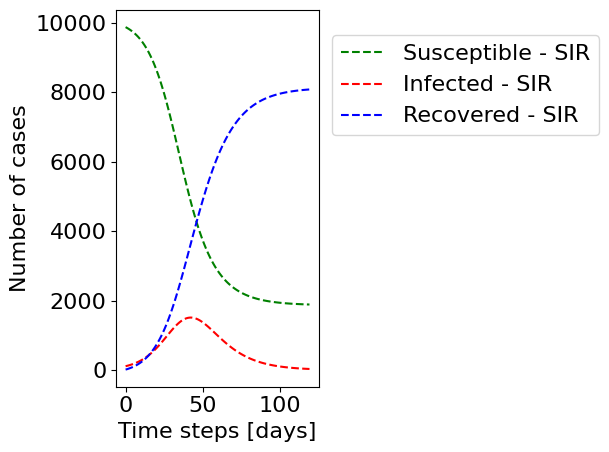

In [12]:
_nAgents = 10000

_randomContacts = 9
_chanceOfInfection = 0.025
_daysCuredAfter = 10

_nSteps = 120

_nPatientZero = 100

x = np.linspace(0,_nSteps-1,_nSteps)
allStats = []

SIRModel = MathModel(_nAgents, _nPatientZero, chanceOfInfection=0.025, randomContacts=9, daysCuredAfter=10)
print("Simulate SIR Model")
for i in tqdm(range(_nSteps)):        
    SIRModel.calculateStep()

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.plot(x,SIRModel.S_,"--", color = "green", label="Susceptible - SIR")
plt.plot(x,SIRModel.I_,"--", color="red", label="Infected - SIR")
plt.plot(x,SIRModel.R_,"--", color="blue", label="Recovered - SIR")

plt.xlabel("Time steps [days]")
plt.ylabel("Number of cases")

lgd = plt.legend(bbox_to_anchor=(1.01,0.8), loc="center left")
plt.tight_layout()

plt.savefig("SIR_baseline.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

In [15]:
def infect(df, contacts, probability=1.0):
    unique, counts = np.unique(contacts, return_counts=True)
    
    roll = np.random.uniform(0,1,len(unique))

    state = df.loc[unique,"state"]
    probability = 1 - np.power(1-probability, counts)
    change = np.array(roll <= probability).astype(int)
    
    df.loc[unique,"state"] = state + np.maximum(change*(1-state),0)

def init(nAgents=1000, nPatientZero=1):
    state = np.zeros(nAgents)

    neighborhood = np.zeros(nAgents)
    data = {"state": state, "neighborhood": neighborhood}

    df = pd.DataFrame(data)
    patientZero = np.random.choice(df.index, nPatientZero, replace=False)
    infect(df, patientZero, probability=1.0)
    return df

def recover(df, probability=1.0):    
    roll = np.random.uniform(0,1,len(df[df["state"] == 1]))
    chance = np.array(roll <= probability).astype(int)
    
    df.loc[df["state"] == 1,"state"] = 1 + chance

def step(df):
    nInfected = np.sum(df["state"] == 1)
    contacts = np.random.choice(df.index, _randomContacts * nInfected, replace=True)

    infect(df, contacts, _chanceOfInfection)
    recover(df, _chanceOfRecovery)


def simulate(df, stats, nSteps=100, mode="random", nRandomContacts=0, plotLattice=False):
    for i in tqdm(range(nSteps)):        
        step(df)
            
        stats["nSusceptible"].append(np.sum(df["state"] == 0))    
        stats["nInfected"].append(np.sum(df["state"] == 1))
        stats["nRemoved"].append(np.sum(df["state"] == 2))

_randomContacts = 9
_chanceOfInfection = 0.025
_daysCuredAfter = 10
_chanceOfRecovery = 1./_daysCuredAfter

_nExperiments = 10
_nAgents = 10000
_nSteps = 150

_nPatientZero = 5

state = np.zeros(_nAgents)
data = {"state": state}
df = pd.DataFrame(data)
df.describe()

,state
count,10000.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [16]:
x = np.linspace(0,_nSteps-1,_nSteps)
allStats = []

SIRModel = MathModel(_nAgents, _nPatientZero, chanceOfInfection=0.025, randomContacts=9, daysCuredAfter=10)
print("Simulate SIR Model")
for i in tqdm(range(_nSteps)):        
    SIRModel.calculateStep()

for iExp in range(_nExperiments):
    print("Starting Experiment:",iExp+1,"/",_nExperiments)
    st = {"nInfected": [], "nRemoved": [], "nSusceptible": []}

    df = init(_nAgents, _nPatientZero)

    simulate(df, stats=st, nSteps=_nSteps)
    
    allStats.append(st)

Math Model initialized with:
Beta: 0.225
Gamma: 0.1
Simulate SIR Model


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 821338.90it/s]


Starting Experiment: 1 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 634.20it/s]


Starting Experiment: 2 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 661.36it/s]


Starting Experiment: 3 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 671.24it/s]


Starting Experiment: 4 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 671.78it/s]


Starting Experiment: 5 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 691.06it/s]


Starting Experiment: 6 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 695.67it/s]


Starting Experiment: 7 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 696.07it/s]


Starting Experiment: 8 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 705.88it/s]


Starting Experiment: 9 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 642.20it/s]


Starting Experiment: 10 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 644.43it/s]


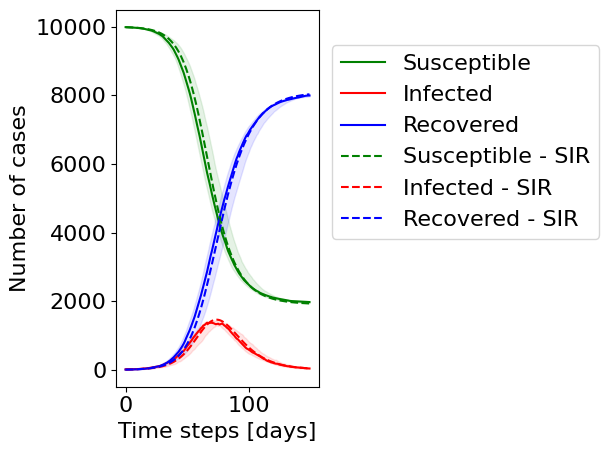

In [17]:
def calculateStats(allStats):
    medianStats = dict()
    lowerStats = dict()
    higherStats = dict()

    for key in allStats[0]:
        l = []
        for st in allStats:
            l.append(st[key])
        a = np.stack(l)
        medianStats[key] = np.median(a, axis=0)
        lowerStats[key] = np.quantile(a, 0.25, axis=0)
        higherStats[key] = np.quantile(a, 0.75, axis=0)
    
    return medianStats, lowerStats, higherStats

def plotSIR(x,mdianStats,lowerStats,higherStats,SIRModel,figName="tmp.png"):
    plt.plot(x,medianStats["nSusceptible"], color = "green", label="Susceptible")
    plt.plot(x,medianStats["nInfected"], color="red", label="Infected")
    plt.plot(x,medianStats["nRemoved"], color="blue", label="Recovered")
    #plt.plot(x,nDead, color="black")
    plt.fill_between(x, lowerStats["nSusceptible"], higherStats["nSusceptible"],
                     color='green', alpha=0.1)
    plt.fill_between(x, lowerStats["nInfected"], higherStats["nInfected"],
                     color='red', alpha=0.1)
    plt.fill_between(x, lowerStats["nRemoved"], higherStats["nRemoved"],
                     color='blue', alpha=0.1)

    plt.plot(x,SIRModel.S_,"--", color = "green", label="Susceptible - SIR")
    plt.plot(x,SIRModel.I_,"--", color="red", label="Infected - SIR")
    plt.plot(x,SIRModel.R_,"--", color="blue", label="Recovered - SIR")

    plt.xlabel("Time steps [days]")
    plt.ylabel("Number of cases")

    lgd = plt.legend(bbox_to_anchor=(1.01,0.65), loc="center left")
    plt.tight_layout()
    
    plt.savefig(figName, bbox_extra_artists=(lgd,), bbox_inches='tight')
   
    plt.show()

medianStats, lowerStats, higherStats = calculateStats(allStats)
plotSIR(x,medianStats,lowerStats,higherStats,SIRModel,figName="CompareToSIR.png")

Math Model initialized with:
Beta: 0.54
Gamma: 0.1
Simulate SIR Model


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 701975.56it/s]


Starting Experiment: 1 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 706.32it/s]


Starting Experiment: 2 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 724.33it/s]


Starting Experiment: 3 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 916.95it/s]


Starting Experiment: 4 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 711.82it/s]


Starting Experiment: 5 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 718.31it/s]


Starting Experiment: 6 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 712.87it/s]


Starting Experiment: 7 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 693.90it/s]


Starting Experiment: 8 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 706.36it/s]


Starting Experiment: 9 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 696.19it/s]


Starting Experiment: 10 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 894.86it/s]


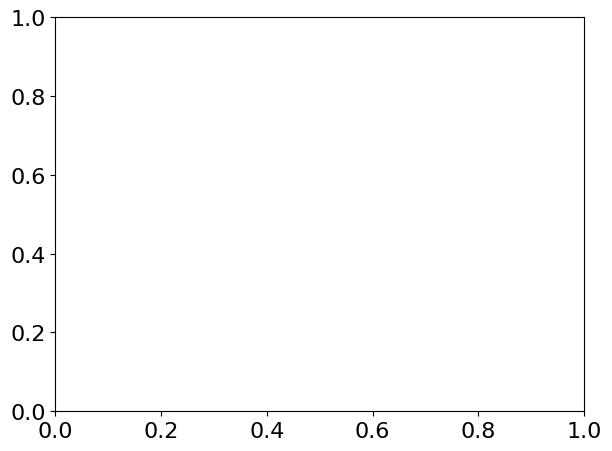

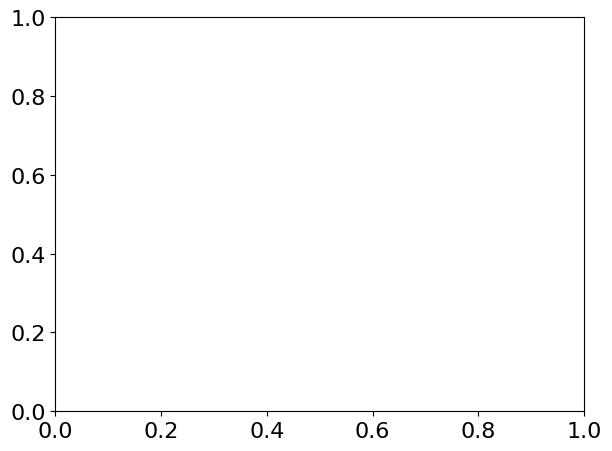

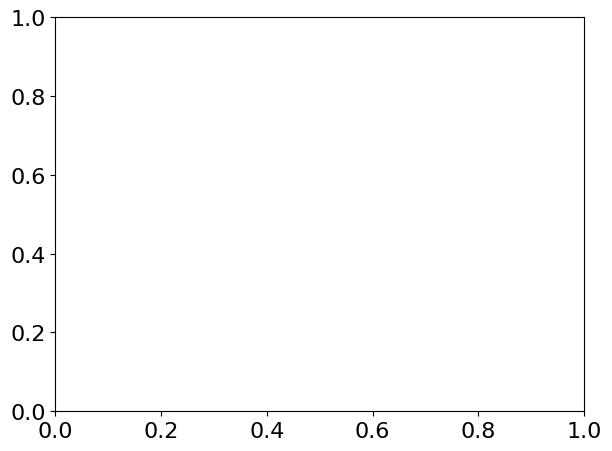

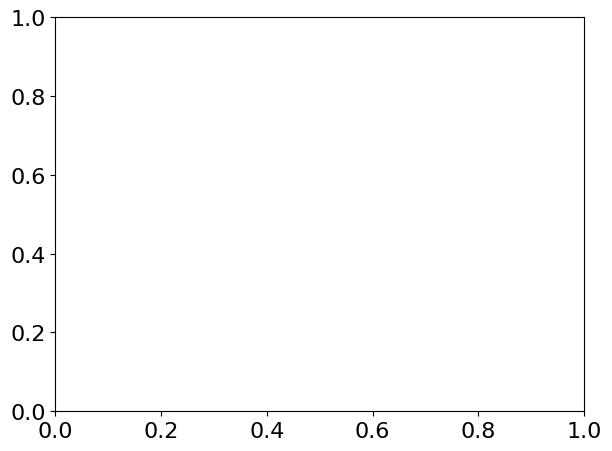

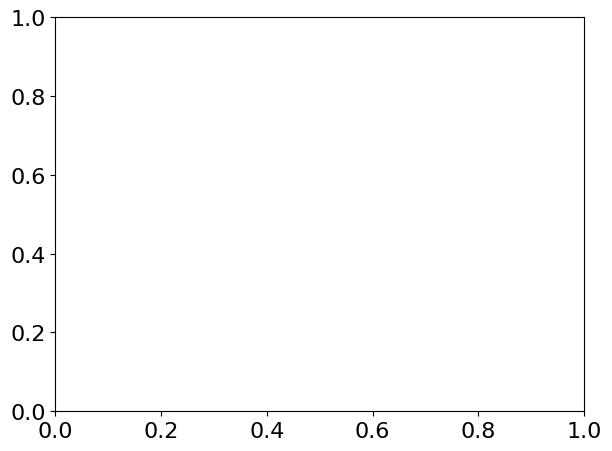

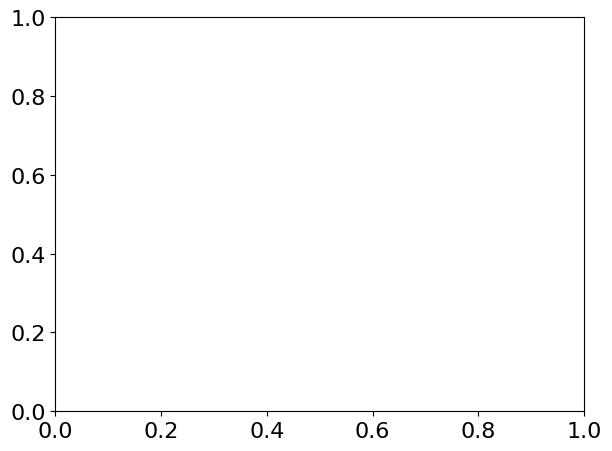

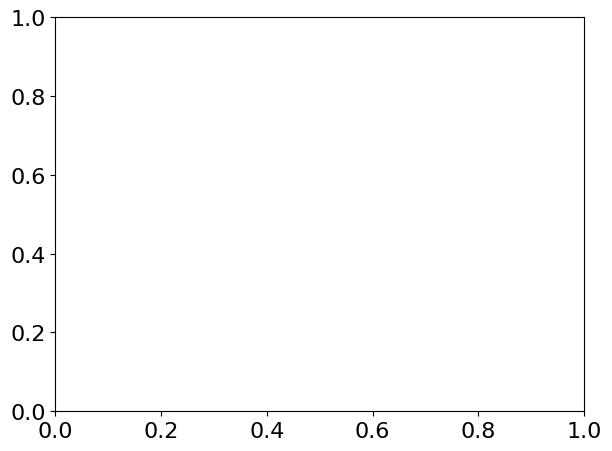

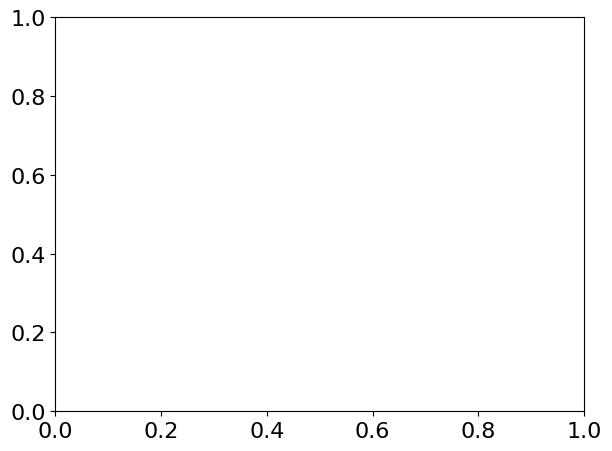

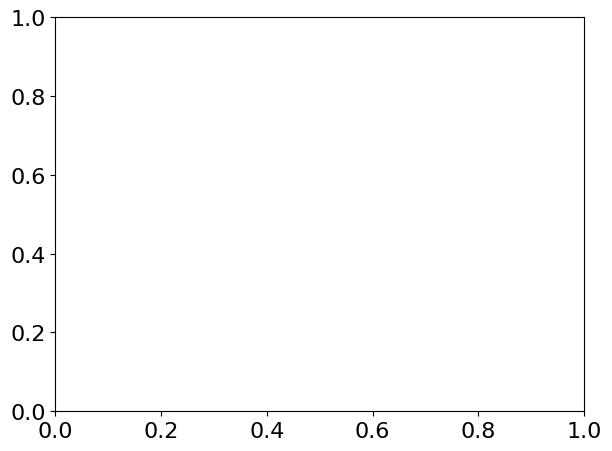

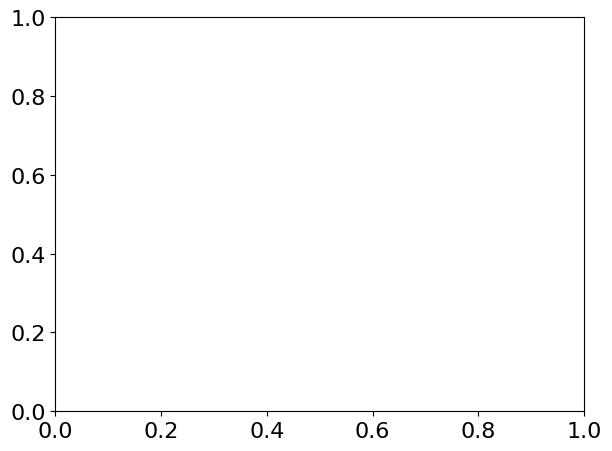

In [22]:
def buildNeighborhoodLattice(df, nRandomContacts=0):
    sideLength = int(np.sqrt(len(df)))
    N = np.array((df.index - sideLength) % len(df)).astype(int)
    E = np.array(np.floor(df.index / sideLength)*sideLength + (df.index % sideLength + 1) % sideLength).astype(int)
    S = np.array((df.index + sideLength) % len(df)).astype(int)
    W = np.array(np.floor(df.index / sideLength)*sideLength + (df.index % sideLength - 1) % sideLength).astype(int)
        
    NE = np.array((E - sideLength) % len(df)).astype(int)
    SE = np.array((E + sideLength) % len(df)).astype(int)
    SW = np.array((W + sideLength) % len(df)).astype(int)
    NW = np.array((W - sideLength) % len(df)).astype(int)
    
    res = [N,E,S,W,NE,SE,SW,NW]
    
    for i in range(0,nRandomContacts):
        res.append(np.random.choice(df.index, len(df), replace=True))
    
    res = np.array(res).T
    return dict(zip(df.index, res))

def step(df, mode="random", neighborhood=None):
    nInfected = np.sum(df["state"] == 1)
    contacts = []
    if mode=="random":
        contacts = np.random.choice(df.index, _randomContacts * nInfected, replace=True)
    elif mode=="lattice":
        #Check that df can be organised in a square
        assert np.floor(np.sqrt(len(df))) * np.floor(np.sqrt(len(df))) == len(df)
                                                    
        contacts = [neighborhood[i] for i in df[df["state"] == 1].index]
        contacts = np.array(contacts).flatten()

    infect(df, contacts, _chanceOfInfection)
    recover(df, _chanceOfRecovery)

def simulate(df, stats, nSteps=100, mode="random", nRandomContacts=0, plotLattice=False):
    neighborhood = buildNeighborhoodLattice(df, nRandomContacts)
    
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
        
    for i in tqdm(range(nSteps)):        
        step(df, mode, neighborhood)
        if plotLattice:
            sideLength = int(np.sqrt(len(df)))
            a = np.array(df["state"] + df["state"]*(2-df["state"]) + df["state"]/2*(1-df["state"])).reshape(sideLength, sideLength)
            plt.imshow(a)
            plt.title("Time step {:03d}".format(i))
            plt.axis('off')
            plt.savefig("gifs/tmp/{:03d}.png".format(i))
            #plt.show()
            
            
        stats["nSusceptible"].append(np.sum(df["state"] == 0))    
        stats["nInfected"].append(np.sum(df["state"] == 1))
        stats["nRemoved"].append(np.sum(df["state"] == 2))

_randomContacts=9
_chanceOfInfection = 0.06

_nSteps = 400

x = np.linspace(0,_nSteps-1,_nSteps)
allStats = []

SIRModel = MathModel(_nAgents, _nPatientZero, _chanceOfInfection, _randomContacts, _daysCuredAfter)
print("Simulate SIR Model")
for i in tqdm(range(_nSteps)):        
    SIRModel.calculateStep()

for iExp in range(_nExperiments):
    print("Starting Experiment:",iExp+1,"/",_nExperiments)
    st = {"nInfected": [], "nRemoved": [], "nSusceptible": []}

    df = init(_nAgents)

    simulate(df, stats=st, nSteps=_nSteps, mode="lattice", nRandomContacts=0, plotLattice=False)
    
    allStats.append(st)


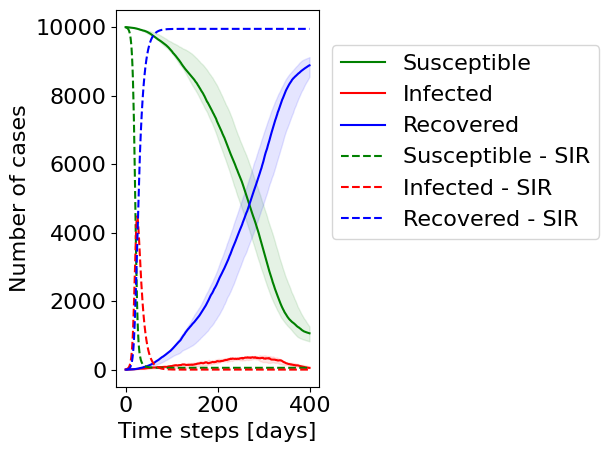

In [23]:
medianStats, lowerStats, higherStats = calculateStats(allStats)
plotSIR(x,medianStats, lowerStats, higherStats, SIRModel)

Math Model initialized with:
Beta: 0.54
Gamma: 0.1
Simulate SIR Model


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 631038.72it/s]


Starting Experiment: 1 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 589.92it/s]


Starting Experiment: 2 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 615.10it/s]


Starting Experiment: 3 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 600.25it/s]


Starting Experiment: 4 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 884.66it/s]


Starting Experiment: 5 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 622.46it/s]


Starting Experiment: 6 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 581.04it/s]


Starting Experiment: 7 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 907.99it/s]


Starting Experiment: 8 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 593.87it/s]


Starting Experiment: 9 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 614.92it/s]


Starting Experiment: 10 / 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 613.20it/s]


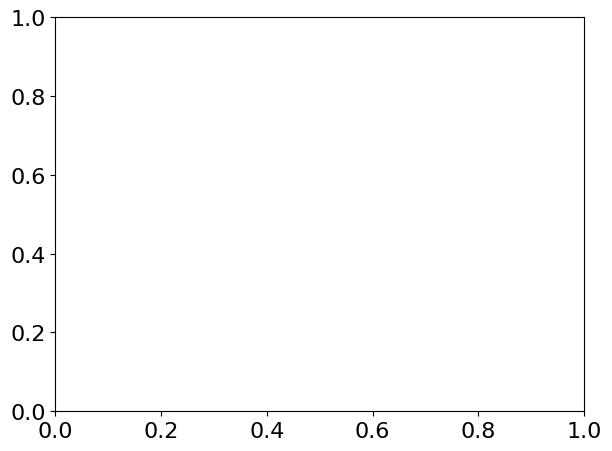

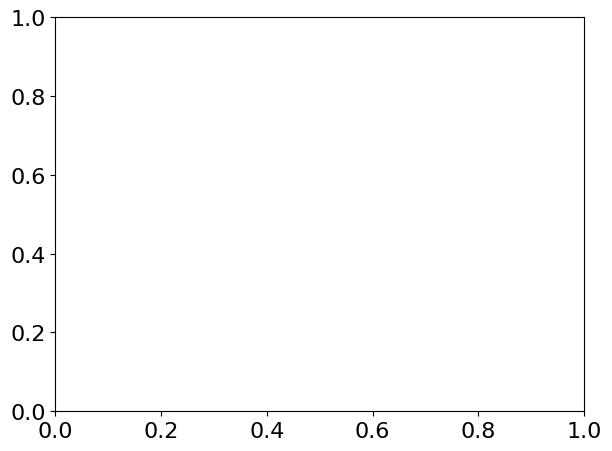

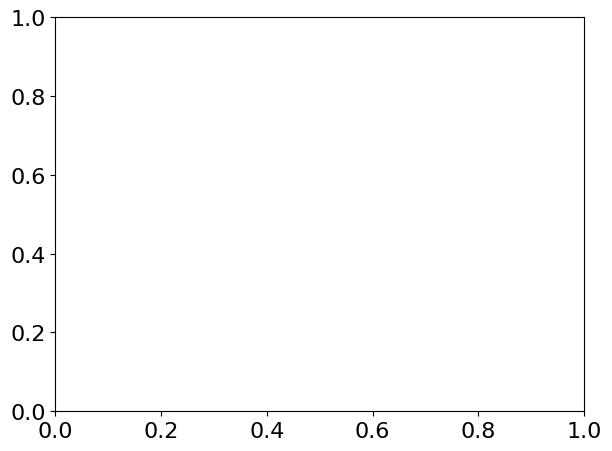

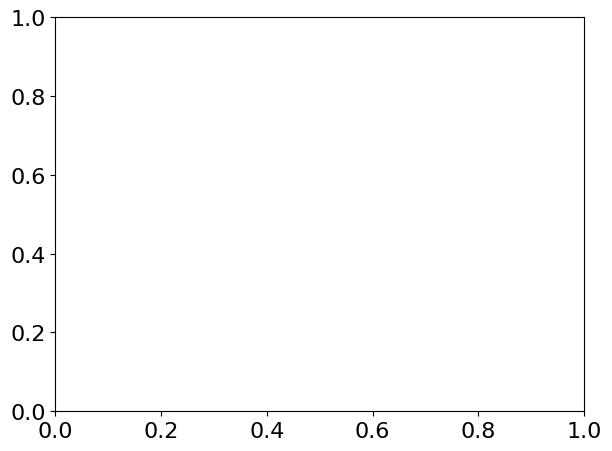

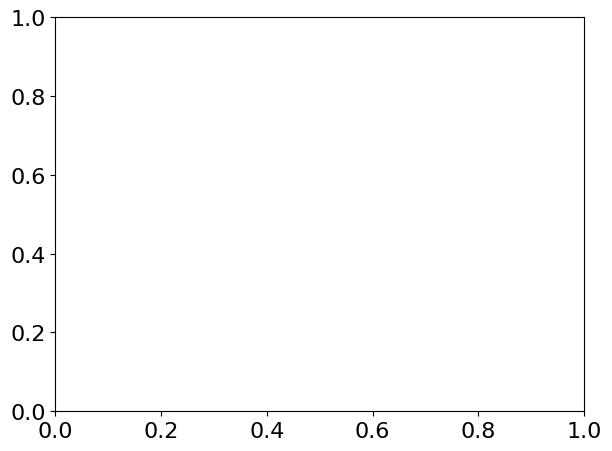

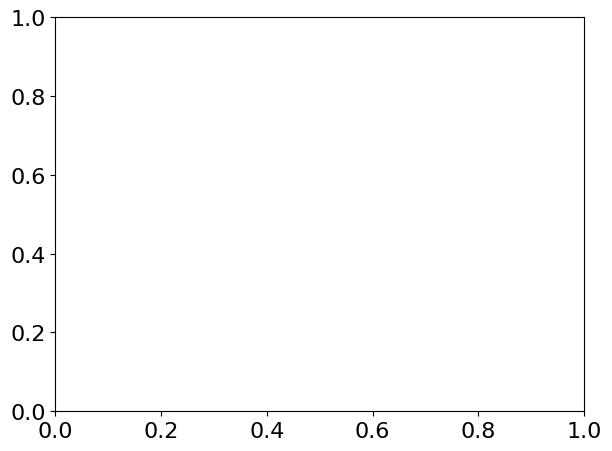

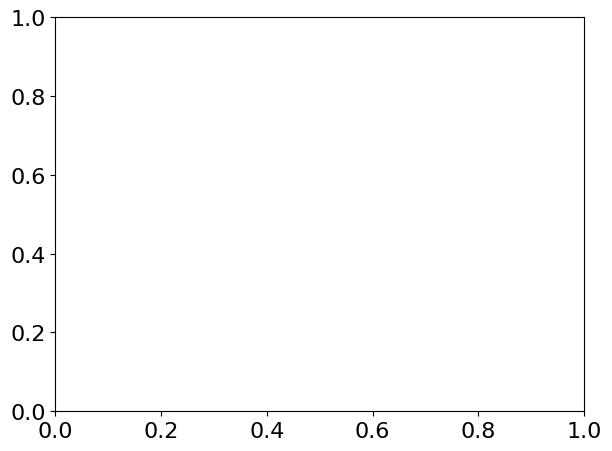

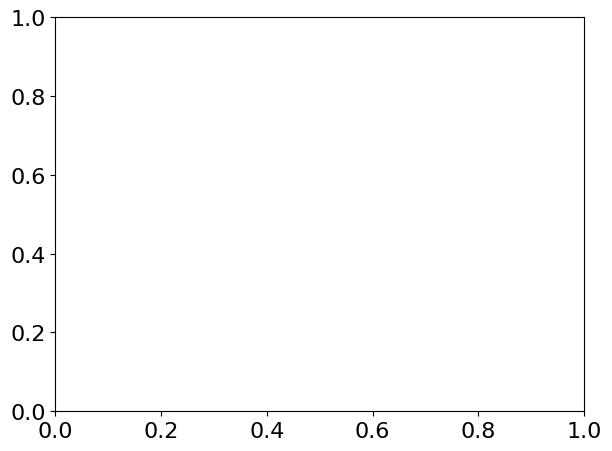

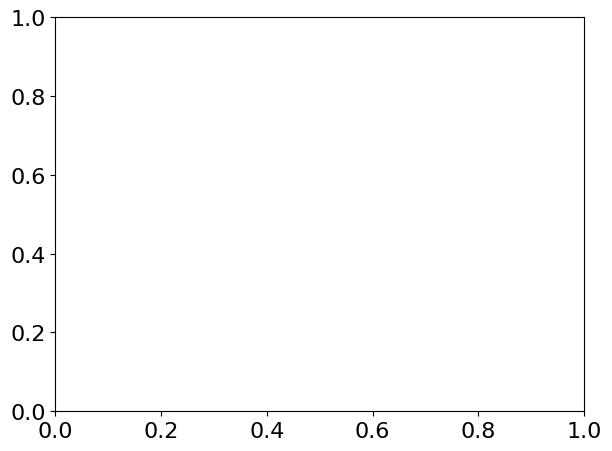

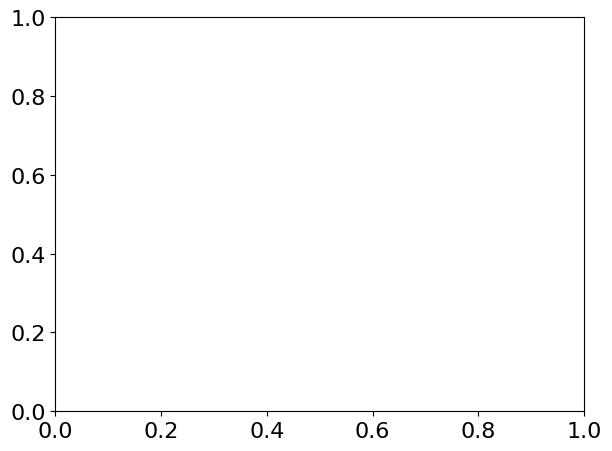

In [24]:
_nSteps = 150

x = np.linspace(0,_nSteps-1,_nSteps)
allStats = []

SIRModel = MathModel(_nAgents, _nPatientZero, _chanceOfInfection, _randomContacts, _daysCuredAfter)
print("Simulate SIR Model")
for i in tqdm(range(_nSteps)):        
    SIRModel.calculateStep()

for iExp in range(_nExperiments):
    print("Starting Experiment:",iExp+1,"/",_nExperiments)
    st = {"nInfected": [], "nRemoved": [], "nSusceptible": []}

    df = init(_nAgents)

    simulate(df, stats=st, nSteps=_nSteps, mode="lattice", nRandomContacts=1, plotLattice=False)
    
    allStats.append(st)


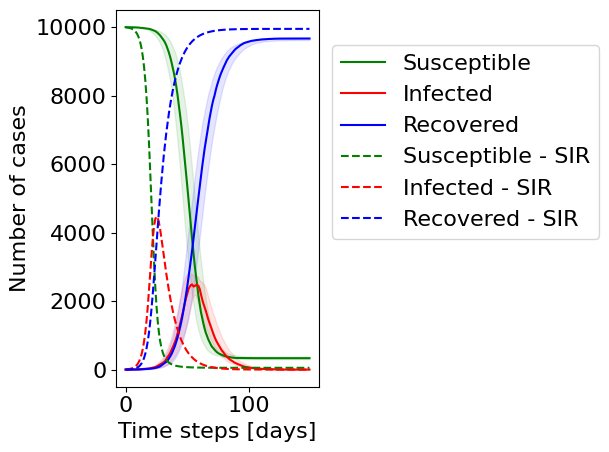

In [25]:
medianStats, lowerStats, higherStats = calculateStats(allStats)
plotSIR(x,medianStats, lowerStats, higherStats, SIRModel)